In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [0]:
os.makedirs('images-gan1', exist_ok=True)
BATCH_SIZE = 64
nc = 3   # no. of channels in training image
nz = 100 # size of input to generator
ngf = 64 # size of feature maps in generator 
ndf = 64 # size of feature maps in discriminator
num_epochs = 100 # no. of epochs
ngpu = 1 # no. of gpus
lr = 0.0002 # learning rate
beta1 = 0.5

In [0]:
image_size = 32
dataset = torchvision.datasets.CIFAR10('./data', 
                                     download=True, 
                                     transform = transforms.Compose([
                                         transforms.ToTensor(),
                                         #transforms.Resize(image_size),
                                         #transforms.CenterCrop(image_size),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [0]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(),
        
        nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(),
        
        nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(),
        
        nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    
  def forward(self, input):
    return self.main(input)

In [0]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(ndf*8, 1, 4, 2, 1, bias=False),
        nn.Sigmoid()
    )
    
  def forward(self, input):
    return self.main(input)

In [0]:
D = Discriminator(ngpu).to(device)
G = Generator(ngpu).to(device)

In [0]:
# Loss functions and optimizers
Tensor = torch.cuda.FloatTensor
criterion = nn.BCELoss()
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_z = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

In [0]:
G(fixed_z).shape

torch.Size([64, 3, 32, 32])

In [0]:
activation = {}
def get_activation(name):
  def hook(G, input, output):
    activation[name] = output.detach()
  return hook

G.main[3].register_forward_hook(get_activation('3'))
G.main[0].register_forward_hook(get_activation('0'))

output = G(fixed_z)
print(activation['0'].shape)
print(activation['3'].shape)

torch.Size([64, 512, 4, 4])
torch.Size([64, 256, 8, 8])


In [0]:
D.train()
G.train()

samples = []
sample_interval = 390

for epoch in range(num_epochs):
  
  for i, data in enumerate(dataloader):
    imgs, _ = data
    imgs = imgs.to(device)
    
    b_size = imgs.shape[0]
    # noise
    z = torch.randn(b_size, nz, 1, 1, device=device)
    r_label = torch.full((b_size,), real_label, device=device)
    
    # ===============
    # Train generator
    # ===============
   
    # Train generator on real labels
    optimizer_G.zero_grad() 
    
    # Output of discriminator on noise
    gen_out = G(z)
    fake_out = D(gen_out)
    
    # Compute loss for generator
    g_loss = criterion(fake_out.view(b_size, 1), r_label)
    
    g_loss.backward()
    optimizer_G.step()
    
    # ====================
    # Train discriminator
    # ====================
    
    optimizer_D.zero_grad()
    real_out = D(imgs)
    
    # Train on real images
    real_loss = criterion(real_out.view(b_size, 1), r_label) 
    
    # Train on fake images
    f_label = torch.full((b_size,), fake_label, device=device)
    fake_loss = criterion(D(G(z).detach()).view(b_size, 1), f_label)
    
    # Compute loss
    d_loss = fake_loss + real_loss
    
    d_loss.backward()
    optimizer_D.step()
    
    batches_done = epoch * len(dataloader) + i
    if batches_done % sample_interval == 0:
      print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch+1, 
                                                                       num_epochs, 
                                                                       i, 
                                                                       len(dataloader), 
                                                                       d_loss.item(), 
                                                                       g_loss.item()))    
    
  G.eval() # eval mode for generating samples
  sample_z = G(fixed_z)
  samples.append(sample_z)
  save_image(to_img(sample_z.data[:64]), 'images-gan1/%d.png' % batches_done, nrow=8, normalize=False)
  G.train()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[Epoch 1/100] [Batch 0/782] [D loss: 1.718800] [G loss: 0.661155]
[Epoch 1/100] [Batch 390/782] [D loss: 0.933486] [G loss: 1.895943]
[Epoch 1/100] [Batch 780/782] [D loss: 1.025705] [G loss: 2.044542]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[Epoch 2/100] [Batch 388/782] [D loss: 0.960528] [G loss: 2.527155]
[Epoch 2/100] [Batch 778/782] [D loss: 0.828090] [G loss: 4.151588]
[Epoch 3/100] [Batch 386/782] [D loss: 0.887714] [G loss: 2.746769]
[Epoch 3/100] [Batch 776/782] [D loss: 0.671255] [G loss: 3.046949]
[Epoch 4/100] [Batch 384/782] [D loss: 1.165589] [G loss: 3.069524]
[Epoch 4/100] [Batch 774/782] [D loss: 1.357483] [G loss: 1.235779]
[Epoch 5/100] [Batch 382/782] [D loss: 1.611743] [G loss: 1.372713]
[Epoch 5/100] [Batch 772/782] [D loss: 1.099206] [G loss: 3.325581]
[Epoch 6/100] [Batch 380/782] [D loss: 0.795283] [G loss: 3.097634]
[Epoch 6/100] [Batch 770/782] [D loss: 1.217179] [G loss: 3.863682]
[Epoch 7/100] [Batch 378/782] [D loss: 1.542347] [G loss: 4.656834]
[Epoch 7/100] [Batch 768/782] [D loss: 1.115637] [G loss: 4.020838]
[Epoch 8/100] [Batch 376/782] [D loss: 1.168073] [G loss: 3.560453]
[Epoch 8/100] [Batch 766/782] [D loss: 0.969252] [G loss: 2.550308]
[Epoch 9/100] [Batch 374/782] [D loss: 0.915073]

In [0]:
import matplotlib.pyplot as plt

def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(6,6), nrows=8, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

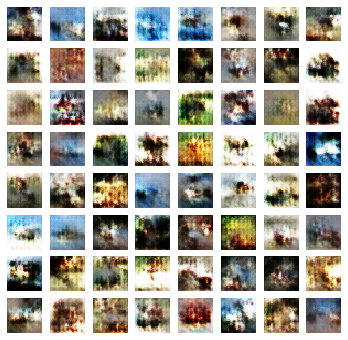

In [137]:
# Generated sample at Epoch = 1
view_samples(0, samples)

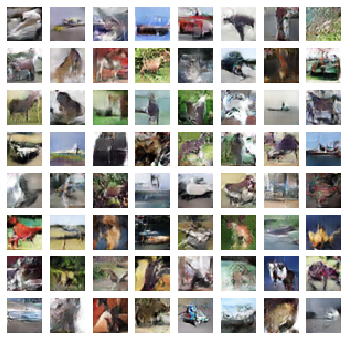

In [138]:
# Generated sample at Epoch = 20
view_samples(19, samples)

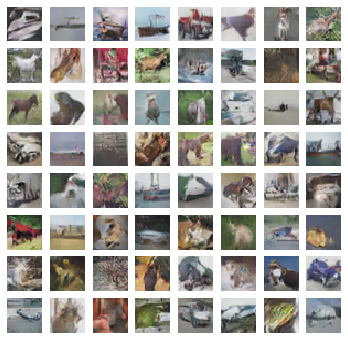

In [139]:
# Generated sample at Epoch = 80
view_samples(70, samples)

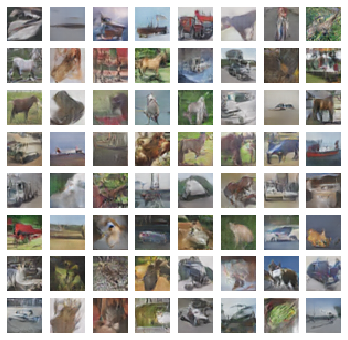

In [136]:
# Generated sample at Epoch = 100
view_samples(99, samples)